<center><img src=https://raw.githubusercontent.com/feast-dev/feast/master/docs/assets/feast_logo.png width=400/></center>

# Credit Risk Model Training

### Introduction

AI models have played a central role in modern credit risk assessment systems. In this example, we develop a credit risk model to predict whether a future loan will be good or bad, given some context data (presumably supplied from the loan application process). We use the modeling process to demonstrate how Feast can be used to facilitate the serving of data for training and inference use-cases.

In this notebook, we train our AI model. We will use the popular scikit-learn library (sklearn) to train a RandomForestClassifier, as this is a relatively easy choice for a baseline model.

### Setup

*The following code assumes that you have read the example README.md file, and that you have setup an environment where the code can be run. Please make sure you have addressed the prerequisite needs.*

In [6]:
!pip install feast

In [7]:
# Imports
import warnings
import datetime
import feast
import joblib
import pandas as pd
import seaborn as sns

from feast import FeatureStore, RepoConfig
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [8]:
# Ignore warnings
warnings.filterwarnings(action="ignore")

In [9]:
# Random seed
SEED = 142

This notebook assumes that you have already done the following:

1. Run the [01_Credit_Risk_Data_Prep.ipynb](01_Credit_Risk_Data_Prep.ipynb) notebook to prepare the data.
2. Run the [02_Deploying_the_Feature_Store.ipynb](02_Deploying_the_Feature_Store.ipynb) notebook to configure the feature stores and launch the feature store servers.

If you have not completed the above steps, please go back and do so before continuing. This notebook relies on the data prepared by 1, and it uses the Feast offline server stood up by 2.

### Load Label (Outcome) Data

From our previous data exploration, remember that the label data represents whether the loan was classed as "good" (1) or "bad" (0). Let's pull the labels for training, as we will use them as our "entity dataframe" when pulling features.

This is also a good time to remember that the label timestamps are lagged by 30-90 days from the context data records.

In [18]:
labels = pd.read_parquet("/content/drive/MyDrive/Feature_Store/data/labels.parquet")

In [19]:
labels.head()

,ID,class,outcome_timestamp
0,0,good,2023-11-24 22:50:13
1,1,bad,2023-11-03 12:10:13
2,2,good,2023-11-30 22:06:03
3,3,good,2023-11-17 07:37:19
4,4,bad,2023-12-01 05:01:48


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Pull Feature Data from Feast Offline Store

In order to pull feature data from the offline store, we create a FeatureStore object that connects to the offline server (continuously running in the previous notebook).

In [22]:
# Create FeatureStore object
# (connects to the offline server deployed in 02_Deploying_the_Feature_Store.ipynb)
store = FeatureStore(config=RepoConfig(
    project="loan_applications",
    provider="local",
    registry="/content/drive/MyDrive/Feature_Store/data/registry.db",
    entity_key_serialization_version=3
))

Now, we can retrieve feature data by supplying our entity dataframe and feature specifications to the `get_historical_features` function. Note that this function performs a fuzzy lookback ("point-in-time") join, matching the lagged outcome timestamp to the closest application timestamp (per ID) in the context data; it also joins the "a" and "b" features that we had previously split into two tables.

To keep this example simple, we will limit our feature set to the numerical features plus two categorical features.

In [34]:
# Get feature data
# (Joins a and b data, and selects records with the right timestamps)

# Ensure 'ID' column in labels is string type to avoid merge errors with Feast
labels['ID'] = labels['ID'].astype(str)

df = store.get_historical_features(
    entity_df=labels,
    features=[
        "data_a:duration",
        "data_a:credit_amount",
        "data_a:installment_commitment",
        "data_b:residence_since", # Corrected feature view
        "data_b:age",             # Corrected feature view
        "data_b:existing_credits",# Corrected feature view
        "data_b:num_dependents",  # Corrected feature view
        "data_a:checking_status", # Corrected feature view
        "data_b:housing",
    ],
).to_df()

Using outcome_timestamp as the event timestamp. To specify a column explicitly, please name it event_timestamp.


In [33]:
fv_b = store.get_feature_view('data_b')
print("Features in data_b:")
for feature in fv_b.features:
    print(feature.name)

Features in data_b:
residence_since
property_magnitude
age
other_payment_plans
housing
existing_credits
job
num_dependents
own_telephone
foreign_worker


In [32]:
fv_a = store.get_feature_view('data_a')
print("Features in data_a:")
for feature in fv_a.features:
    print(feature.name)

Features in data_a:
checking_status
duration
credit_history
purpose
credit_amount
savings_status
employment
installment_commitment
personal_status
other_parties


In [30]:
# List all feature views available in the project
for fv in store.list_feature_views():
    print(fv.name)

data_b
data_a


In [35]:
# Check the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   ID                      995 non-null    object             
 1   class                   995 non-null    category           
 2   outcome_timestamp       995 non-null    datetime64[ns, UTC]
 3   duration                994 non-null    float64            
 4   credit_amount           994 non-null    float64            
 5   installment_commitment  994 non-null    float64            
 6   checking_status         994 non-null    object             
 7   residence_since         994 non-null    float64            
 8   age                     994 non-null    float64            
 9   existing_credits        994 non-null    float64            
 10  num_dependents          994 non-null    float64            
 11  housing                 994 non-null    objec

Now, we can retrieve feature data by supplying our entity dataframe and feature specifications to the `get_historical_features` function. Note that this function performs a fuzzy lookback ("point-in-time") join, matching the lagged outcome timestamp to the closest application timestamp (per ID) in the context data; it also joins the "a" and "b" features that we had previously split into two tables.

To keep this example simple, we will limit our feature set to the numerical features plus two categorical features.

In [25]:
# Convert 'ID' column in labels to string type to avoid merge errors
labels['ID'] = labels['ID'].astype(str)

### Split the Data

Next, we split the data into a `train` and `validate` set, which we will use to train and then validate a model. The validation set will allow us to more accurately assess the model's performance on data that it has not seen during the training phase.

In [36]:
# Split data into train and validate datasets
train, validate = train_test_split(df, test_size=0.2, random_state=SEED)

### Exploratory Data Analysis

Before building a model, a data scientist needs to gain understanding of the data to make sure it meets important statistical assumptions, and to identify potential opportunities and issues. As the purpose of this particular example is to show working with Feast, we will take the view of a data scientist looking to build a quick baseline model to establish some low-end metrics.

Note that this data set is very "clean", as it has already been prepared. In real-life, production credit risk data can be much more complex, and have many issues that need to be understood and addressed before modeling.

Let's look at counts for the target variable `class`, which tells us whether a (historical) loan was good or bad. We can see that there were many more good loans than bad, making the dataset imbalanced.

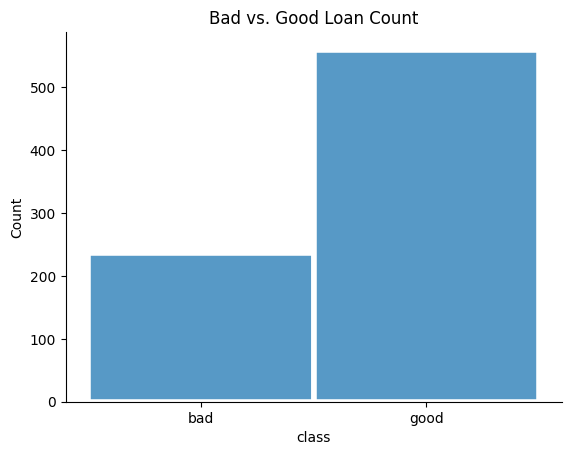

In [37]:
# plot the target variable "class"
p = sns.histplot(train["class"], ec="w", lw=4)
_ = p.set_title("Bad vs. Good Loan Count")
_ = p.spines["top"].set_visible(False)
_ = p.spines["right"].set_visible(False)

Now, view the first few records of the context data.

In [38]:
# View first records in training data
train.head()

,ID,class,outcome_timestamp,duration,credit_amount,installment_commitment,checking_status,residence_since,age,existing_credits,num_dependents,housing
454,454,bad,2023-11-10 09:27:46+00:00,64.0,558.0,1.0,no checking,4.0,56.0,1.0,1.0,rent
379,379,good,2023-11-23 18:23:39+00:00,37.0,839.0,3.0,no checking,1.0,30.0,4.0,2.0,rent
504,504,bad,2023-11-23 20:20:07+00:00,39.0,3380.0,2.0,0<=X<200,3.0,66.0,3.0,1.0,rent
656,656,bad,2023-12-02 20:35:01+00:00,55.0,12102.0,1.0,0<=X<200,3.0,28.0,3.0,2.0,rent
123,123,good,2023-11-20 00:55:24+00:00,8.0,9862.0,2.0,no checking,2.0,23.0,4.0,1.0,own


### Feature Engineering

Once data columns have been prepared so that they can be used to train an AI model, it is common to refer to them as "features". The process of preparing features is referred to as "feature engineering".

Below, we will train a random forest model. Random forests are relatively robust to non-standardized, non-normalized data, making it easier for us to getting started. As such, the numerical columns are ready for a simple baseline training.

We have pulled two categorical columns, wich we will need to engineer into numerical features.

The `checking_status` column tells us roughly how much money the applicant has in their checking account, while the `housing` column shows the applicant's housing status. We presume that more money in checking correlates inversely with credit risk, while owing vs. renting, vs. living for free correlates directly with credit risk. Hence, converting these to ordinal features makes sense. Of course, in a real study we would want to quantitatively verify these presumptions.

In [39]:
# Inspect the `checking_status` column distibution
train.checking_status.value_counts(normalize=True)

,proportion
checking_status,
0<=X<200,0.354717
<0,0.330818
no checking,0.314465


In [40]:
# Inspect the `housing` column distribution
train.housing.value_counts(normalize=True)

,proportion
housing,
rent,0.345912
for free,0.332075
own,0.322013


We define a tranformer that can be used to convert `checking_status` and `housing` to ordinal variables. The transformer will also drop the non-feature columns (`class`, `ID`, and `application_timestamp`) from the feature data.

In [41]:
# Feature lists
cat_features = ["checking_status", "housing"]
num_features = [
    "duration", "credit_amount", "installment_commitment",
    "residence_since", "age", "existing_credits", "num_dependents"
]

# Ordinal encoder for cat_features
# (We use a ColumnTransformer to passthrough numerical feature columns)
col_transform = ColumnTransformer([
        ("cat_features", OrdinalEncoder(), cat_features),
        ("num_features", "passthrough", num_features),
    ],
    remainder="drop",
)

In [42]:
# Check the tranform outputs features as expected
# (Note: transform output is an array, so we convert it
# back to dataframe for inspection)
pd.DataFrame(
    index=train.index,
    columns=cat_features + num_features,
    data= col_transform.fit_transform(train)
).head()

,checking_status,housing,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
454,2.0,2.0,64.0,558.0,1.0,4.0,56.0,1.0,1.0
379,2.0,2.0,37.0,839.0,3.0,1.0,30.0,4.0,2.0
504,0.0,2.0,39.0,3380.0,2.0,3.0,66.0,3.0,1.0
656,0.0,2.0,55.0,12102.0,1.0,3.0,28.0,3.0,2.0
123,2.0,1.0,8.0,9862.0,2.0,2.0,23.0,4.0,1.0


Finally, let's separate out the labels, and engineer them from categorical ("good" | "bad") to float (1.0 | 0.0). We do this for both the training and validation data.

In [43]:
# Make "class" target variable numeric
train_y = (train["class"] == "good").astype(float)
validate_y = (validate["class"] == "good").astype(float)

### Train the Model

Now that the features are prepared, we can train (fit) our baseline model on the feature data.

In [44]:
# Specify the model
rf_model = RandomForestClassifier(
    n_estimators=400,
    criterion="entropy",
    max_depth=4,
    min_samples_leaf=10,
    class_weight={0:5, 1:1},
    random_state=SEED
)

# Package transform and model in pipeline
model = Pipeline([("transform", col_transform), ("rf_model", rf_model)])

In [45]:
# Fit the model
model.fit(train, train_y)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat_features',
                                                  OrdinalEncoder(),
                                                  ['checking_status',
                                                   'housing']),
                                                 ('num_features', 'passthrough',
                                                  ['duration', 'credit_amount',
                                                   'installment_commitment',
                                                   'residence_since', 'age',
                                                   'existing_credits',
                                                   'num_dependents'])])),
                ('rf_model',
                 RandomForestClassifier(class_weight={0: 5, 1: 1},
                                        criterion='entropy', max_depth=4,
                                        min_samples_leaf=10, n_estimators=400,
                                        random_state=142))])

### Evaluate the Model

Let's evaluate our baseline model performance. With credit risk, recall is going to be an important measure to look at. We compare the performance on the training data, with the performance on the validation data through a classification report.

In [46]:
# Evaluate training set performance
train_preds = model.predict(train)
print(classification_report(train_y, train_preds))

              precision    recall  f1-score   support

         0.0       0.30      1.00      0.47       236
         1.0       1.00      0.04      0.07       560

    accuracy                           0.32       796
   macro avg       0.65      0.52      0.27       796
weighted avg       0.79      0.32      0.19       796



In [47]:
# Evaluate validation data performance
print(classification_report(validate_y, model.predict(validate)))

              precision    recall  f1-score   support

         0.0       0.31      0.97      0.47        61
         1.0       0.71      0.04      0.07       138

    accuracy                           0.32       199
   macro avg       0.51      0.50      0.27       199
weighted avg       0.59      0.32      0.19       199



The recall on the validation set for bad loans (0 class) is 0.87, meaning that the model correctly identified close to 90% of the bad loans. However, the precision of 0.46 tells us that the model is also classifying many loans that were actually good as bad. Precision and recall are technical metrics. In order to truly assess the models value, we would need feedback from the business side on the impact of misclassifications (for both good and bad loans).

The difference in performance on the training vs. validation data, tells us that the model is slightly overfitting the data. Remember that this is just a quick baseline model. To improve further, we could do things like:
- gather more data
- engineer features
- experiment with hyperparameter settings
- experiment with other model types

In fact, this is just a start. Creating AI models that meet business needs often requires a lot of guided experimentation.

### Save the Model

The last thing we do is save our trained model, so that we can pick it up later in the serving environment.

In [48]:
# Save the model to a pickle file
joblib.dump(model, "/content/drive/MyDrive/Feature_Store/rf_model.pkl")

['/content/drive/MyDrive/Feature_Store/rf_model.pkl']

In the next notebook, [04_Credit_Risk_Model_Serving.ipynb](04_Credit_Risk_Model_Serving.ipynb), we will load the trained model and request predictions, with input features provided by the Feast online feature server.